# Variational Auto-Encoder

The objective of a generative model is to represent (*modeling*) the distribution $p(x)$ of observed data $x$. Once the distribution $p(x)$ is obtained, new (pseudo) data can be generated (*sampling*) from that distribution.

![Figure 1](../figures/distributions.png)

In the realm of data modeling, starting with the simplest cases often sets the groundwork for understanding more complex scenarios. 
Consider the first illustration, where data is modeled using a single Gaussian distribution—a case of profound simplicity. 
However, the reality of the data we encounter in the world is rarely so straightforward.

As we move towards more intricate examples, like those depicted in the middle and right illustrations, it becomes evident that the data observed in real-world applications often possesses complex distributions. 
These complexities challenge us to develop models that can flexibly adapt to the actual shapes and behaviors of data. This is where Variational Autoencoders (VAEs) come into play.

VAEs are a class of latent variable models designed to address these challenges by providing a robust framework for modeling data distributions that are difficult to capture with traditional methods. 
By leveraging the principles of probabilistic inference and deep learning, VAEs enable us to approximate these complex distributions with remarkable precision and flexibility.

## Overview of VAE

One of the representative latent variable models is the Variational Auto-Encoder (VAE). 
The idea in VAE is that the model learns to generate the data by encoding the observed data into a latent space (as a latent variable) and restoring the original observed data. 
The encoding and restoring (decoding) processes are conducted with neural networks. 
A main difference between VAE and other latent variable models is that, in VAE, the latent variable $z$ is generated from a fixed normal distribution.

![Figure 6](../figures/part2-vae.png)

Recall that the objective of the generative model is to obtain the distribution $p(x)$ of the observed data $x$. 
Therefore, the neural network decoder should be modeled as $p(x|z) $. 
However, the neural network output is a vector, so it cannot be directly used as the distribution. 
To this end, we consider using a normal distribution whose mean vector is the output of the neural network decoder. 
This can be represented as the following equations, where $\theta$ is the parameters of the neural network decoder. For simplicity, we set the covariance matrix to a unit matrix $\text{I}$ .

$$\begin{align*}
p(z) &= \mathcal{N}(z; 0, \text{I})\\
\hat{x} &= \text{NeuralNetwork}(z;\theta) \\
p_\theta(x|z) &= \mathcal{N}(x; \hat{x}, \text{I})
\end{align*}$$

For the encoder, since the latent variable in VAE is assumed to be generated from a fixed normal distribution, the transformation process from the observed variable to the latent variable can be modeled as follows, where $\phi$ is the parameters of the neural network encoder.

$$\begin{align*}
\mu, \sigma &= \text{NeuralNetwork}(x;\phi) \\
q_\phi(z|x) &= \mathcal{N}(z; \mu, \sigma^2\text{I}) 
\end{align*}$$

## Parameter Estimation for VAE

Similar to the EM algorithm, here we consider using ELBO to maximize the log-likelihood function of the model. With observed data (samples) $\mathcal{D}=\{x^{(1)}, x^{(2)}, ..., x^{(N)}\}$ ELBO of VAE can be calculated as follows.

$$\begin{align*}
\text{ELBO}(\mathcal{D};\theta,\phi) &= \sum_{x\in\mathcal{D}}\int q_\phi(z|x)\log\frac{p_\theta(x,z)}{q_\phi(z|x)} dz\\
\end{align*}$$

Let’s consider ELBO of one sample $\text{ELBO}(x;\theta,\phi)$.

$$\begin{align*}
\text{ELBO}(x;\theta,\phi) &= \int q_\phi(z|x)\log\frac{p_\theta(x,z)}{q_\phi(z|x)} dz\\
&= \int q_\phi(z|x)\log\frac{p_\theta(x|z)p(z)}{q_\phi(z|x)} dz\\
&= \int q_\phi(z|x)\log{p_\theta(x|z)}dz + \int{q_\phi(z|x)}\log\frac{p(z)}{q_\phi(z|x)}  dz\\
&= \int q_\phi(z|x)\log{p_\theta(x|z)}dz - \int{q_\phi(z|x)}\log\frac{q_\phi(z|x)}{p(z)}  dz\\
&= \mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right] - D_{\text{KL}}(q_\phi(z|x)\|p(z))
\end{align*}$$

The first part, $\mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right]$ , is an expectation value of $\log p_\theta(x|z)$, thus, can be approximately calculated with Monte Carlo method as follows, where $x_d, \hat{x}_d$ are $d$-th component of $D$-dimension vector $x, \hat{x}$, respectively.

$$\begin{align*}
\mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right] & \approx  \log p_\theta(x|z) \\
&\approx \log \mathcal{N}(x; \hat{x},\text{I})\\
&= \log\left(\frac{1}{\sqrt{(2\pi)^D|\text{I}|}}\exp\left(-\frac{1}{2}(x-\hat{x})^\top(x-\hat{x})\right)\right) \\
&= -\frac{1}{2}\sum_{d=1}^{D}(x_d-\hat{x}_d)^2 + \text{const}
\end{align*}$$

```{margin}
KL Divergence Between Two Normal Distributions

The Kullback-Leibler (KL) divergence between two normal distributions $ q(z) = \mathcal{N}(z; \mu_q, \sigma_q) $ and $ p(z) = \mathcal{N}(z; \mu_p, \sigma_p) $ is calculated as follows:

$$
D_{KL}(q(z) \| p(z)) = - \frac{1}{2}\sum_{h=1}^{H}\left(1+\log\frac{\sigma_{q,h}^2}{\sigma_{p,h}^2}-\frac{(\mu_{q,h}-\mu_{p,h})^2}{\sigma_{p,h}^2}-\frac{\sigma_{q,h}^2}{\sigma_{q,h}^2}\right)
$$

This formula provides a measure of the information lost when $ q(z) $ is used to approximate $ p(z) $.
```

```{margin}

```

The second part, $D_{\text{KL}}(q_\phi(z|x)\|p(z))$, is the KL divergence between two normal distributions. Thus, it can be obtained as follows, where $\mu_h , \sigma_h$ are $h$-th component of $H$-dimension vectors $\mu, \sigma$ (output of the neural network encoder).

$$D_{\text{KL}}(q_\phi(z|x)\|p(z)) = -\frac{1}{2}\sum_{h=1}^{H}(1+\log \sigma_h^2-\mu_h^2-\sigma_h^2)$$

Hence, the ELBO can be obtained as follows.

$$\text{ELBO}(x;\theta,\phi)\approx -\frac{1}{2}\sum_{d=1}^{D}(x_d-\hat{x}_d)^2 +\frac{1}{2}\sum_{h=1}^{H}(1+\log \sigma_h^2-\mu_h^2-\sigma_h^2) + \text{const}$$

We need to maximize this ELBO to estimate the parameters for the VAE model. However, with neural networks, it is more natural to do minimization on a loss function. Thus, we can define a loss function for neural network encoder and decoder training.

$$\text{Loss}(x; \theta, \phi) \approx \sum_{d=1}^D(x_d-\hat{x}_d)^2 - \sum_{h=1}^H(1+\log \sigma_h^2-\mu_h^2-\sigma_h^2)$$

## A Practical Example: Image Generation with VAE

![FashionMNIST](../figures/chapter3/fashion_mnist-3.0.1.png)

### Step 1: Import Necessary Libraries

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

### Step 2: Define the Encoder and Decoder

Both the encoder and decoder will be modeled as simple Multi-Layer Perceptrons (MLPs).

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.log_var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        x = torch.relu(self.linear(x))
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

In [3]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = torch.relu(self.linear(z))
        return torch.sigmoid(self.out(z))


### Step 3: Define the VAE

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim)

    # Reparameterization Trick
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 28*28))
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

    def loss_function(self, recon_x, x, mu, log_var):
        BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD

### Training

In [5]:
from tqdm import tqdm

# Data loading
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Model, Optimizer, and Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 784  # 28 * 28 image
hidden_dim = 256
latent_dim = 128
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Training Loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = model.loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # if batch_idx % 100 == 0:
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #    epoch, batch_idx * len(data), len(train_loader.dataset),
            #    100. * batch_idx / len(train_loader), loss.item() / len(data)))

    #print('====> Epoch: {} Average loss: {:.4f}'.format(
        # epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)
    
# Run the training
loss_history = []
num_epochs = 30
for epoch in tqdm(range(1, num_epochs + 1)):
    loss = train(epoch)
    loss_history.append(loss)

  0%|                                                                                                                          | 0/30 [00:00<?, ?it/s]

  3%|███▊                                                                                                              | 1/30 [00:02<01:16,  2.62s/it]

  7%|███████▌                                                                                                          | 2/30 [00:04<01:06,  2.39s/it]

 10%|███████████▍                                                                                                      | 3/30 [00:06<00:58,  2.17s/it]

 13%|███████████████▏                                                                                                  | 4/30 [00:08<00:53,  2.07s/it]

 17%|███████████████████                                                                                               | 5/30 [00:10<00:49,  2.00s/it]

 20%|██████████████████████▊                                                                                           | 6/30 [00:12<00:47,  1.97s/it]

 23%|██████████████████████████▌                                                                                       | 7/30 [00:14<00:44,  1.95s/it]

 27%|██████████████████████████████▍                                                                                   | 8/30 [00:16<00:42,  1.93s/it]

 30%|██████████████████████████████████▏                                                                               | 9/30 [00:18<00:41,  1.96s/it]

 33%|█████████████████████████████████████▋                                                                           | 10/30 [00:20<00:38,  1.95s/it]

 37%|█████████████████████████████████████████▍                                                                       | 11/30 [00:22<00:37,  1.98s/it]

 40%|█████████████████████████████████████████████▏                                                                   | 12/30 [00:24<00:35,  1.99s/it]

 43%|████████████████████████████████████████████████▉                                                                | 13/30 [00:26<00:35,  2.10s/it]

 47%|████████████████████████████████████████████████████▋                                                            | 14/30 [00:28<00:33,  2.09s/it]

 47%|████████████████████████████████████████████████████▋                                                            | 14/30 [00:29<00:34,  2.14s/it]

KeyboardInterrupt: 

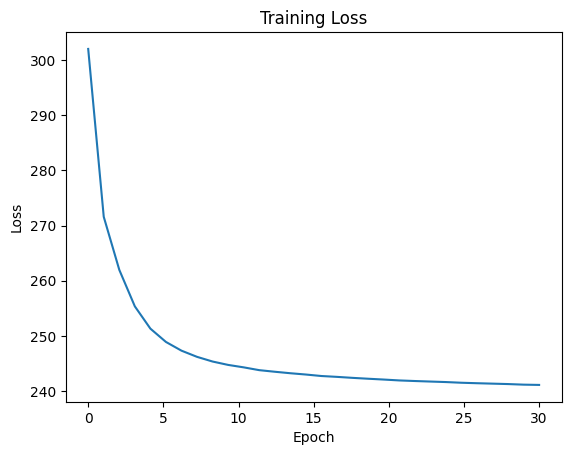

In [6]:
plt.plot(np.linspace(0, num_epochs, num_epochs), loss_history, "-")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Generate New Image

In [7]:
def generate_images(model, num_images=10):
    model.eval()
    with torch.no_grad():
        # Sample z from the prior (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = model.decoder(z)

        generated_images = generated_images.view(num_images, 28, 28).cpu().numpy()

        fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=num_images, sharey=True, sharex=True)
        for i in range(num_images):
            ax[i].imshow(generated_images[i], cmap='gray')
            ax[i].axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

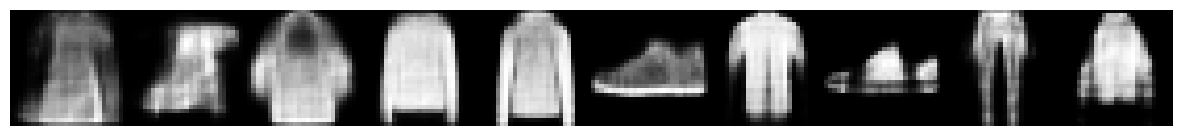

In [8]:
generate_images(model)

## Hierarchical VAE

VAE is an effective generative model that is applied to many generative tasks. While there is only one latent variable in VAE, increasing the number of latent variables to form a hierarchy version of VAE can improve the representation capability of the model on more complex observed data. 

![Figure 8](../figures/part2-hie-vae.png)

However, as you may have noticed, as the number of latent variables increases, the numbers of encoder and decoder also increase. This leads to many parameters to be trained, which is generally computationally high-cost. 